## Goal: Build classifier to distinguish AD converters
see paper: https://www.cell.com/current-biology/pdfExtended/S0960-9822(20)30291-8

In [1]:
library(data.table)
library(tidyverse)
library(RColorBrewer)
library(reshape2)
library(gdata)
library(ggrepel)
library(DESeq2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

The following objects are masked from ‘package:data.table’:

    dcast, melt

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: Unable to load perl libaries needed by read.xls()
gdata: to support 'XLSX' (Excel 2007+) files.

gdata: Run the function 'installXLSXsupport()'
gdata: to automatically d

In [2]:
setwd("~/coursework//cse283/project/")

In [12]:
# Read in counts table
counts.dt <- fread("./GSE136243_gene_TPM_all_samples.txt",stringsAsFactors = F)
head(counts.dt)

gene_id         gene_name    gene_biotype                       C_1_01_1
1 ENSG00000223972 DDX11L1      transcribed_unprocessed_pseudogene 0       
2 ENSG00000227232 WASH7P       unprocessed_pseudogene             0       
3 ENSG00000278267 MIR6859-1    miRNA                              0       
4 ENSG00000243485 RP11-34P13.3 lincRNA                            0       
5 ENSG00000274890 MIR1302-2    miRNA                              0       
6 ENSG00000237613 FAM138A      lincRNA                            0       
  AD_8_12_1 C_10_01_1 C_10_14_1 C_10_05_1 C_10_08_1 AD_11_08_1 ⋯ AD_5_12_1
1 0         0         0         0         0         0          ⋯ 0        
2 0         0         0         0         0         0          ⋯ 0        
3 0         0         0         0         0         0          ⋯ 0        
4 0         0         0         0         0         0          ⋯ 0        
5 0         0         0         0         0         0          ⋯ 0        
6 0         0         0         0         0         0          ⋯ 0        
  AD_5_13_1 AD_3_00_1 AD_3_01_1 AD_3_03_1 AD_2_01_1 AD_2_02_1 AD_2_03_1
1 0         0         0         0         0         0         0        
2 0         0         0         0         0         0         0        
3 0         0         0         0         0         0         0        
4 0         0         0         0         0         0         0        
5 0         0         0         0         0         0         0        
6 0         0         0         0         0         0         0        
  AD_2_05_1 AD_2_07_1
1  0.00000  0.000000 
2 11.62609  5.503961 
3  0.00000  0.000000 
4  0.00000  0.000000 
5  0.00000  0.000000 
6  0.00000  0.000000

In [60]:
# get sample names and add to meta table
samp.dt <- data.frame(sample_id=colnames(counts.dt)[4:length(colnames(counts.dt))],stringsAsFactors = F) %>%
    mutate(donorID = sapply(sample_id,function(x) {
        t <- str_split(x,"_")[[1]]
        return(paste0(t[1],"_",t[2]))
    })) %>%
    mutate(year = as.numeric(sapply(sample_id,function(x) {
        t <- str_split(x,"_")[[1]]
        return(paste0("20",t[3]))
    }))) 
# head(samp.dt)

### Sample information table + year away from AD diagnosis
meta.dt <- fread("./donor_info.csv",stringsAsFactor=F) %>%
    full_join(.,samp.dt,by="donorID") %>%
    mutate(yr_since_diag = as.numeric(year)-as.numeric(Year_diagnosis))
meta.dt

sample_id donorID year
1 C_1_01_1  C_1     2001
2 AD_8_12_1 AD_8    2012
3 C_10_01_1 C_10    2001
4 C_10_14_1 C_10    2014
5 C_10_05_1 C_10    2005
6 C_10_08_1 C_10    2008

donorID group     age_death sex braak_stage Year_diagnosis APOE_status
1   N_1     control   86        M   1           NA             ε3/ε4      
2   N_1     control   86        M   1           NA             ε3/ε4      
3   N_1     control   86        M   1           NA             ε3/ε4      
4   N_1     control   86        M   1           NA             ε3/ε4      
5   N_1     control   86        M   1           NA             ε3/ε4      
6   N_2     control   93        F   1           NA             ε3/ε3      
7   N_2     control   93        F   1           NA             ε3/ε3      
8   N_2     control   93        F   1           NA             ε3/ε3      
9   N_2     control   93        F   1           NA             ε3/ε3      
10  N_2     control   93        F   1           NA             ε3/ε3      
11  N_3     control   86        M   1           NA             ε2/ε3      
12  N_3     control   86        M   1           NA             ε2/ε3      
13  N_3     control   86        M   1           NA             ε2/ε3      
14  N_3     control   86        M   1           NA             ε2/ε3      
15  N_4     control   83        M   1           NA             ε3/ε3      
16  N_4     control   83        M   1           NA             ε3/ε3      
17  N_4     control   83        M   1           NA             ε3/ε3      
18  N_4     control   83        M   1           NA             ε3/ε3      
19  N_4     control   83        M   1           NA             ε3/ε3      
20  N_5     control   89        M   2           NA             ε3/ε3      
21  N_5     control   89        M   2           NA             ε3/ε3      
22  N_5     control   89        M   2           NA             ε3/ε3      
23  N_5     control   89        M   2           NA             ε3/ε3      
24  N_5     control   89        M   2           NA             ε3/ε3      
25  N_6     control   96        F   2           NA             ε3/ε3      
26  N_6     control   96        F   2           NA             ε3/ε3      
27  N_6     control   96        F   2           NA             ε3/ε3      
28  N_6     control   96        F   2           NA             ε3/ε3      
29  N_6     control   96        F   2           NA             ε3/ε3      
30  N_7     control   83        F   2           NA             ε3/ε4      
⋮   ⋮       ⋮         ⋮         ⋮   ⋮           ⋮              ⋮          
135 C_5     converter 93        F   5           2005           ε3/ε3      
136 C_5     converter 93        F   5           2005           ε3/ε3      
137 C_6     converter 92        M   6           2012           ε2/ε4      
138 C_6     converter 92        M   6           2012           ε2/ε4      
139 C_6     converter 92        M   6           2012           ε2/ε4      
140 C_6     converter 92        M   6           2012           ε2/ε4      
141 C_7     converter 96        F   5           2011           ε3/ε4      
142 C_7     converter 96        F   5           2011           ε3/ε4      
143 C_7     converter 96        F   5           2011           ε3/ε4      
144 C_7     converter 96        F   5           2011           ε3/ε4      
145 C_8     converter 89        M   5           2006           ε3/ε3      
146 C_8     converter 89        M   5           2006           ε3/ε3      
147 C_8     converter 89        M   5           2006           ε3/ε3      
148 C_8     converter 89        M   5           2006           ε3/ε3      
149 C_8     converter 89        M   5           2006           ε3/ε3      
150 C_9     converter 85        F   6           2006           ε3/ε4      
151 C_9     converter 85        F   6           2006           ε3/ε4      
152 C_9     converter 85        F   6           2006           ε3/ε4      
153 C_9     converter 85        F   6           2006           ε3/ε4      
154 C_10    converter 96        F   5           2007           ε3/ε3      
155 C_10    converter 96        F   5           2007           ε3/ε3      
156 C_10    converter 96     

In [61]:
# counts table into long format and join in sample info
counts.longdt <- counts.dt %>%
    melt(id.vars=c("gene_id", "gene_name", "gene_biotype"), value.name = "count", variable.name = "sample_id") %>%
    left_join(.,meta.dt,by="sample_id")
head(counts.longdt)

# Save file
fwrite(counts.longdt, "./gene_counts_sample_info.csv", row.names = F)

Warning message:
“Column `sample_id` joining factor and character vector, coercing into character vector”

gene_id         gene_name    gene_biotype                       sample_id
1 ENSG00000223972 DDX11L1      transcribed_unprocessed_pseudogene C_1_01_1 
2 ENSG00000227232 WASH7P       unprocessed_pseudogene             C_1_01_1 
3 ENSG00000278267 MIR6859-1    miRNA                              C_1_01_1 
4 ENSG00000243485 RP11-34P13.3 lincRNA                            C_1_01_1 
5 ENSG00000274890 MIR1302-2    miRNA                              C_1_01_1 
6 ENSG00000237613 FAM138A      lincRNA                            C_1_01_1 
  count donorID group     age_death sex braak_stage Year_diagnosis APOE_status
1 0     C_1     converter 91        F   3           2010           ε3/ε4      
2 0     C_1     converter 91        F   3           2010           ε3/ε4      
3 0     C_1     converter 91        F   3           2010           ε3/ε4      
4 0     C_1     converter 91        F   3           2010           ε3/ε4      
5 0     C_1     converter 91        F   3           2010           ε3/ε4      
6 0     C_1     converter 91        F   3           2010           ε3/ε4      
  year yr_since_diag
1 2001 -9           
2 2001 -9           
3 2001 -9           
4 2001 -9           
5 2001 -9           
6 2001 -9

### DESEQ

In [5]:
counts.mat <- counts.dt %>%
    select(meta.dt$sample_id) %>% # ensure columns are in same order as meta dt
    as.matrix   
rownames(counts.mat) <- counts.dt$gene_id

# round counts for DESeq
counts.mat <- round(counts.mat)
head(counts.mat)

N_1_01_1 N_1_05_1 N_1_07_1 N_1_08_1 N_1_09_1 N_2_00_1 N_2_01_1
ENSG00000223972 0        0        0        0        0        1        0       
ENSG00000227232 0        0        1        0        0        0        0       
ENSG00000278267 0        0        0        0        0        0        0       
ENSG00000243485 0        0        0        0        0        0        0       
ENSG00000274890 0        0        0        0        0        0        0       
ENSG00000237613 0        0        0        0        0        0        0       
                N_2_03_1 N_2_06_1 N_2_08_1 ⋯ C_10_14_1 C_10_05_1 C_10_08_1
ENSG00000223972   0      1        0        ⋯ 0         0         0        
ENSG00000227232   0      0        0        ⋯ 0         0         0        
ENSG00000278267 120      0        0        ⋯ 0         0         0        
ENSG00000243485   0      0        0        ⋯ 0         0         0        
ENSG00000274890   0      0        0        ⋯ 0         0         0        
ENSG00000237613   0      0        0        ⋯ 0         0         0        
                C_10_03_1 C_10_10_1 C_10_13_1 C_11_09_1 C_11_01_1 C_11_03_1
ENSG00000223972 0         0          0        0         0         0        
ENSG00000227232 0         0         26        0         0         0        
ENSG00000278267 0         0          0        0         0         0        
ENSG00000243485 3         0          0        8         0         0        
ENSG00000274890 0         0          0        0         0         0        
ENSG00000237613 0         0          0        0         0         0        
                C_11_04_1
ENSG00000223972 0        
ENSG00000227232 0        
ENSG00000278267 0        
ENSG00000243485 0        
ENSG00000274890 0        
ENSG00000237613 0

In [80]:
### run DESeq for condition - take a long time
dds <- DESeqDataSetFromMatrix(counts.mat, colData = meta.dt, design = ~group) 

# run DESeq for 
start.time <- Sys.time()
dds <- DESeq(dds)
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 12533 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


Time difference of 22.20379 mins

In [81]:
# pull out top genes DE between AD and controls
res <- results(dds, contrast=c("group", "control","AD")) %>%
    as.data.frame() %>%
    rownames_to_column("gene_id") %>%
    left_join(., distinct(select(counts.dt, gene_id,gene_name,gene_biotype)), by = "gene_id") %>%
    arrange(padj)
head(res)
fwrite(res, "./control_AD_DE_genes.csv",row.names=F)

gene_id         baseMean  log2FoldChange lfcSE    stat      pvalue      
1 ENSG00000281338 13.259123 -23.15224      1.613139 -14.35230 1.030678e-46
2 ENSG00000201097 10.185959 -24.47529      1.741652 -14.05292 7.392169e-45
3 ENSG00000212468 12.848607 -25.03897      1.870570 -13.38574 7.326077e-41
4 ENSG00000200130 12.674200 -24.63962      1.996408 -12.34198 5.381759e-35
5 ENSG00000251934  9.727488 -24.08894      1.962551 -12.27430 1.244645e-34
6 ENSG00000273960 10.880075 -24.58290      2.030785 -12.10513 9.921668e-34
  padj         gene_name  gene_biotype
1 5.403430e-42 AC020636.1 miRNA       
2 1.937709e-40 RNU6-366P  snRNA       
3 1.280256e-36 RNU6-754P  snRNA       
4 7.053603e-31 SNORA63    snoRNA      
5 1.305035e-30 RNU6-1143P snRNA       
6 8.669223e-30 AL645937.1 miRNA

In [82]:
# res %>%
#     filter(padj < 0.05) %>% head(n=50)

In [7]:
# # simple PCA of different samples
# # regularized log transform count data to log2 scale for variance stabilizing effect, convert to matrix
# start.time <- Sys.time()
# rld <- assay(varianceStabilizingTransformation(dds))
# pca <- prcomp(t(rld))
# summary(pca)
# end.time <- Sys.time()
# time.taken <- end.time - start.time
# time.taken

In [8]:
# # Plot PCA
# pca.dt <- cbind(meta.dt, pca$x)
# ggplot(pca.dt, aes(x=PC1, PC2, color = group)) + geom_point() #+ geom_text_repel()

In [83]:
# vs <- vst(counts.mat)
# pca <- prcomp(t(vs))
# summary(pca)
# end.time <- Sys.time()
# time.taken <- end.time - start.time
# time.taken

In [9]:
## compute PCA
pca <- prcomp(t(counts.mat))
summary(pca)

Importance of components:
                             PC1       PC2       PC3       PC4       PC5
Standard deviation     5.967e+04 2.447e+04 1.479e+04 1.011e+04 7.867e+03
Proportion of Variance 7.433e-01 1.250e-01 4.566e-02 2.133e-02 1.292e-02
Cumulative Proportion  7.433e-01 8.683e-01 9.140e-01 9.353e-01 9.483e-01
                             PC6       PC7       PC8       PC9      PC10
Standard deviation     7.499e+03 5.761e+03 4151.0881 3.626e+03 3.519e+03
Proportion of Variance 1.174e-02 6.930e-03    0.0036 2.750e-03 2.590e-03
Cumulative Proportion  9.600e-01 9.669e-01    0.9705 9.733e-01 9.759e-01
                            PC11      PC12      PC13      PC14      PC15
Standard deviation     3.119e+03 2.865e+03 2.568e+03 2.208e+03 2.138e+03
Proportion of Variance 2.030e-03 1.710e-03 1.380e-03 1.020e-03 9.500e-04
Cumulative Proportion  9.779e-01 9.796e-01 9.810e-01 9.820e-01 9.830e-01
                            PC16      PC17      PC18      PC19      PC20
Standard deviation     1.

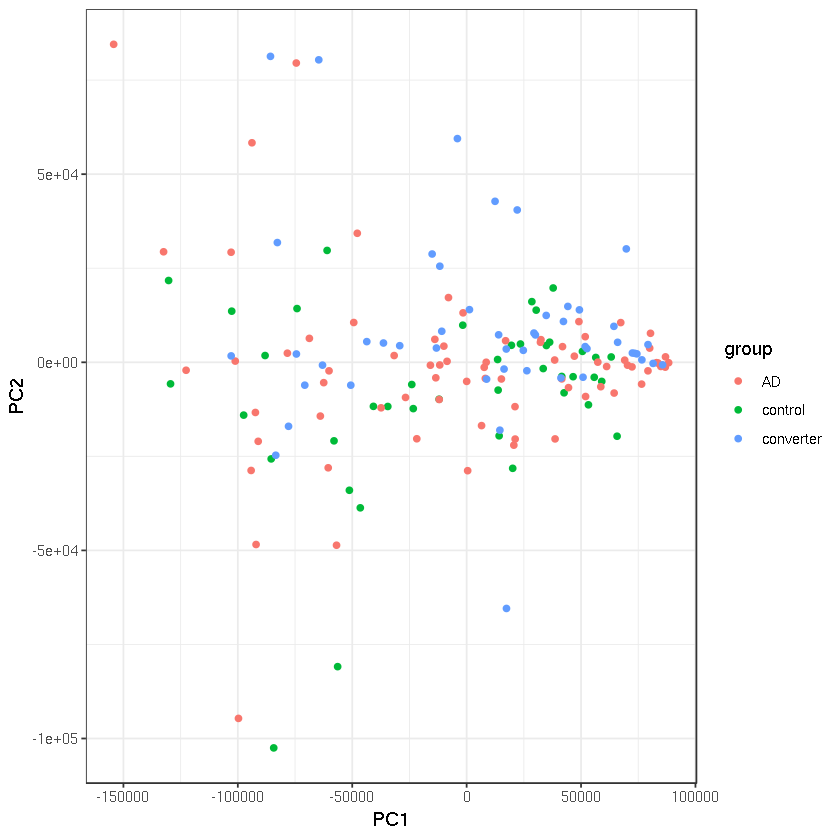

In [11]:
# Plot PCA
pca.dt <- cbind(meta.dt, pca$x)
ggplot(pca.dt, aes(x=PC1, PC2, color = group)) + geom_point() + theme_bw()

## Look into AMP-AD genes

In [33]:
ampgenes <- c("PBXIP1", "MID1IP1", "SLC25A18", "GFAP", "GNA12", "CRTAP", "QDPR", "GPRC5B", "PADI2",
             "NACC2", "RHOQ", "QKI", "CSRP1", "CALD1", "SASH1", "TNS3", "LAMP2", "ERBB2IP", "FAM107A",
             "PLXNB1", "AHNAK", "MYO10", "PDE4DIP", "ITPKB", "KCNJ10", "DOCK1","MRAS","PHGDH")


up.ampgenes <- c( "PADI2","NACC2", "RHOQ", "QKI", "CSRP1", "CALD1", "SASH1", "TNS3", "LAMP2", 
                 "ERBB2IP", "FAM107A","PLXNB1", "AHNAK", "MYO10", "PDE4DIP", "ITPKB", "KCNJ10", 
                 "DOCK1","MRAS","PHGDH")

down.ampgenes <- c("PBXIP1", "MID1IP1", "SLC25A18", "GFAP", "GNA12", "CRTAP", "QDPR", "GPRC5B")


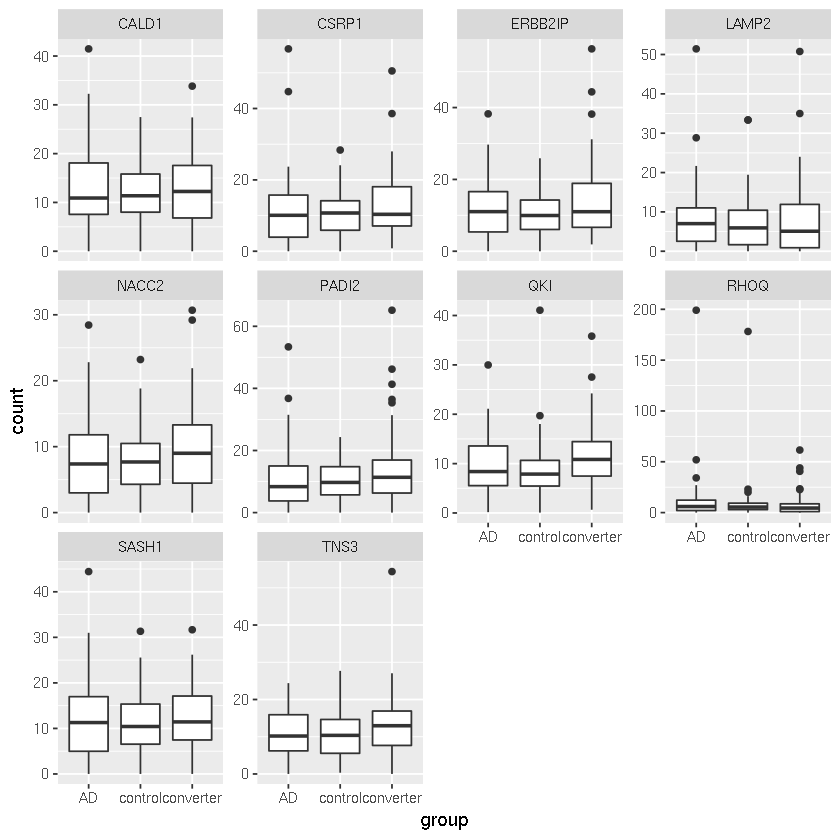

In [52]:
dt <- counts.longdt %>%
    filter(gene_name %in% up.ampgenes[1:10]) 
# dt 

ggplot(dt, aes(x=group, y = count)) + 
    geom_boxplot() + 
    facet_wrap(~gene_name, scales="free_y")

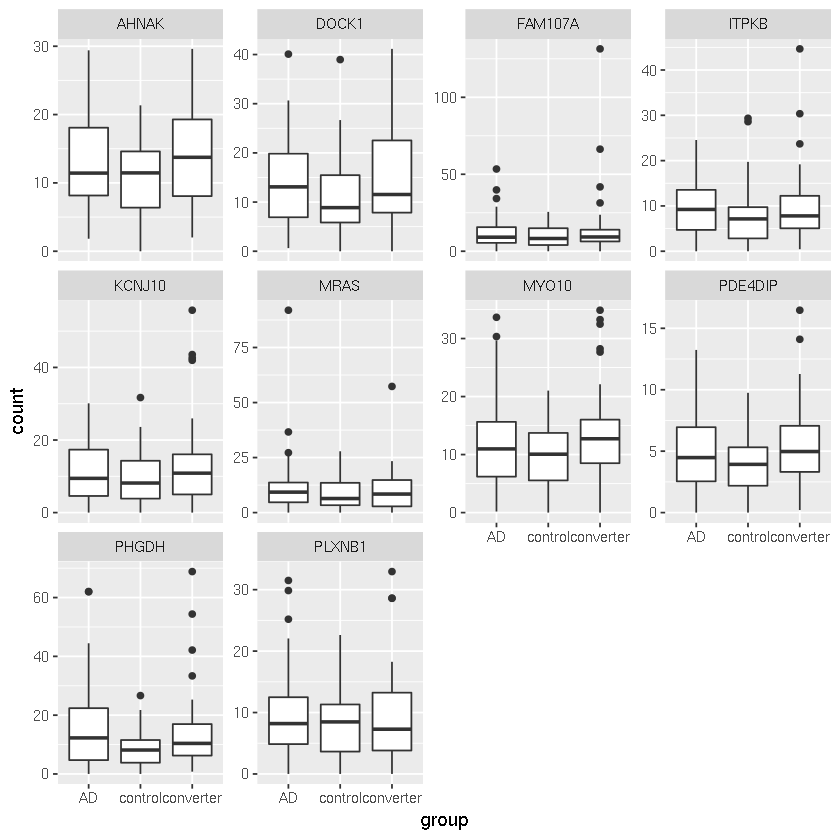

In [54]:
dt <- counts.longdt %>%
    filter(gene_name %in% up.ampgenes[11:20]) 
# dt 

ggplot(dt, aes(x=group, y = count)) + 
    geom_boxplot() + 
    facet_wrap(~gene_name, scales="free_y")
# most AMP - AD genes are also upregulated in this data

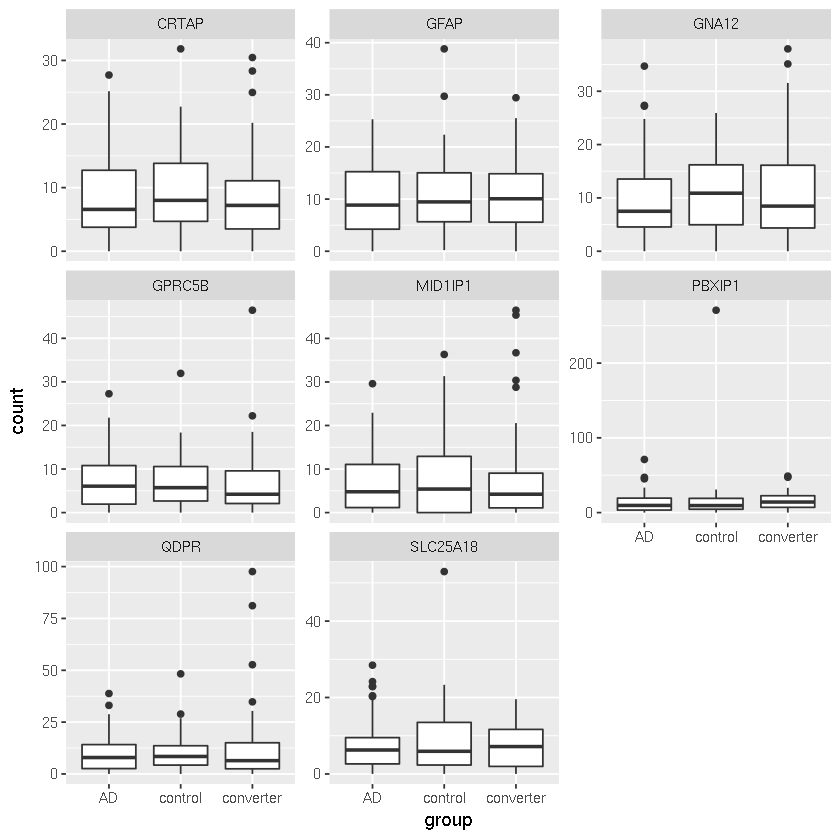

In [63]:
dt <- counts.longdt %>%
    filter(gene_name %in% down.ampgenes) 
# dt 

ggplot(dt, aes(x=group, y = count)) + 
    geom_boxplot() + 
    facet_wrap(~gene_name, scales="free_y")
# only some AMP-AD genes are also downreg in this data

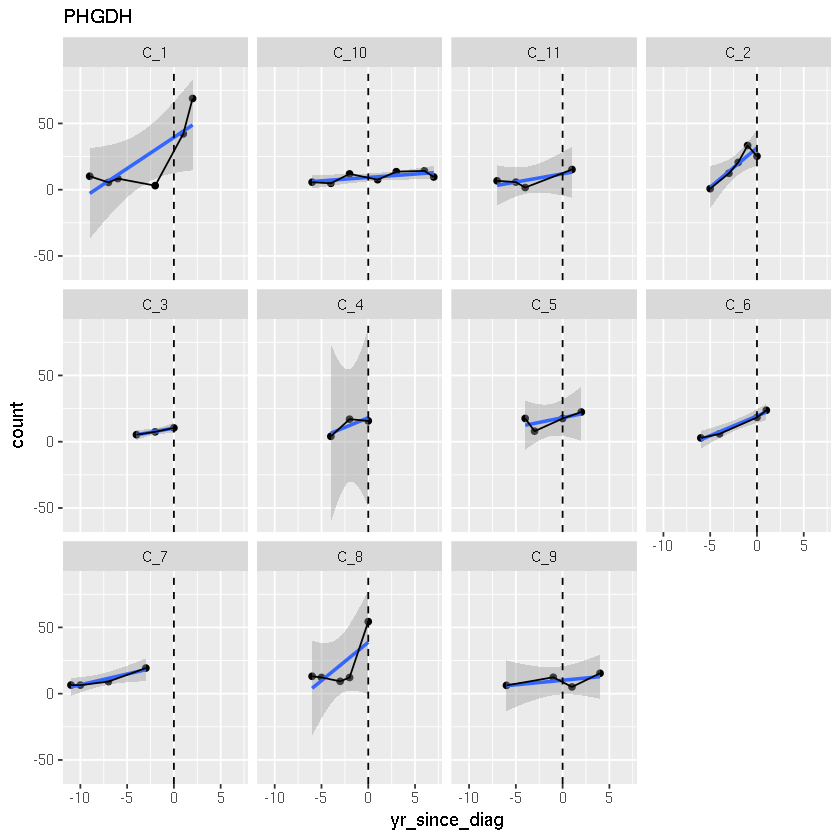

In [76]:
# plot converters for PHGDH
dt <- counts.longdt %>%
    filter(gene_name %in% ampgenes[28], group=="converter")
# dt
ggplot(dt, aes(x=yr_since_diag,y=count)) + geom_point() + geom_smooth(method =  "lm") +
    geom_vline(xintercept = 0, linetype= "dashed") + 
    geom_line() + facet_wrap(~donorID) + ggtitle(ampgenes[28])

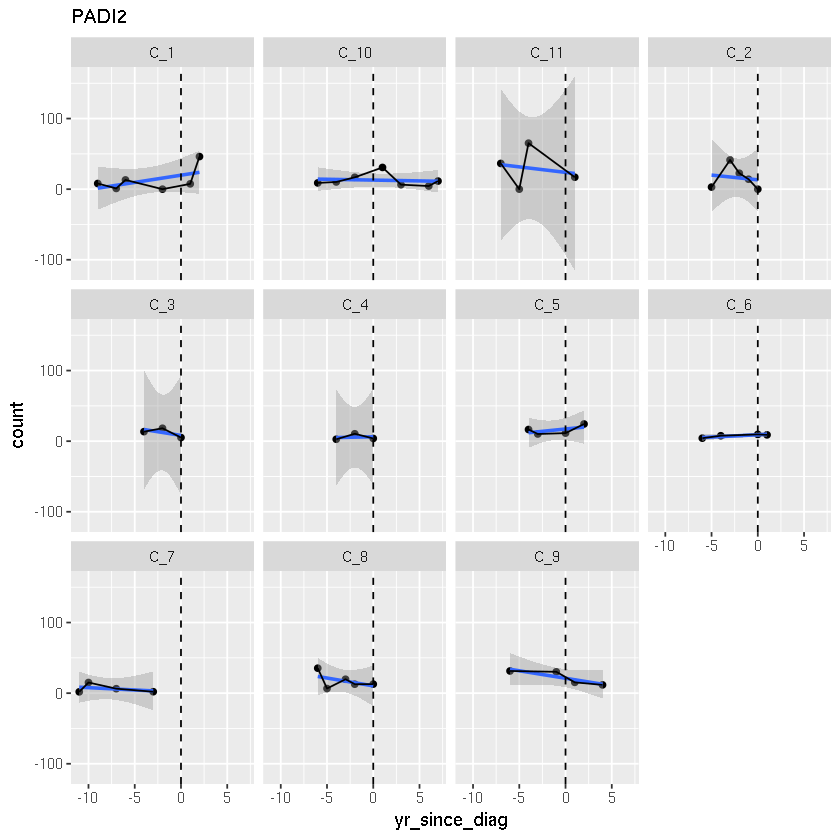

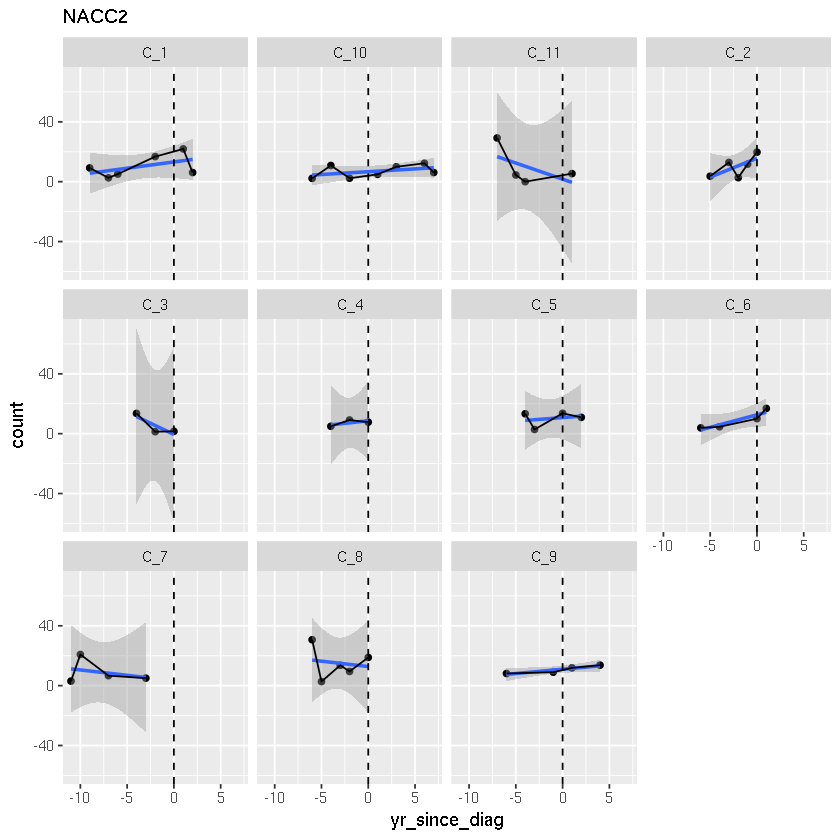

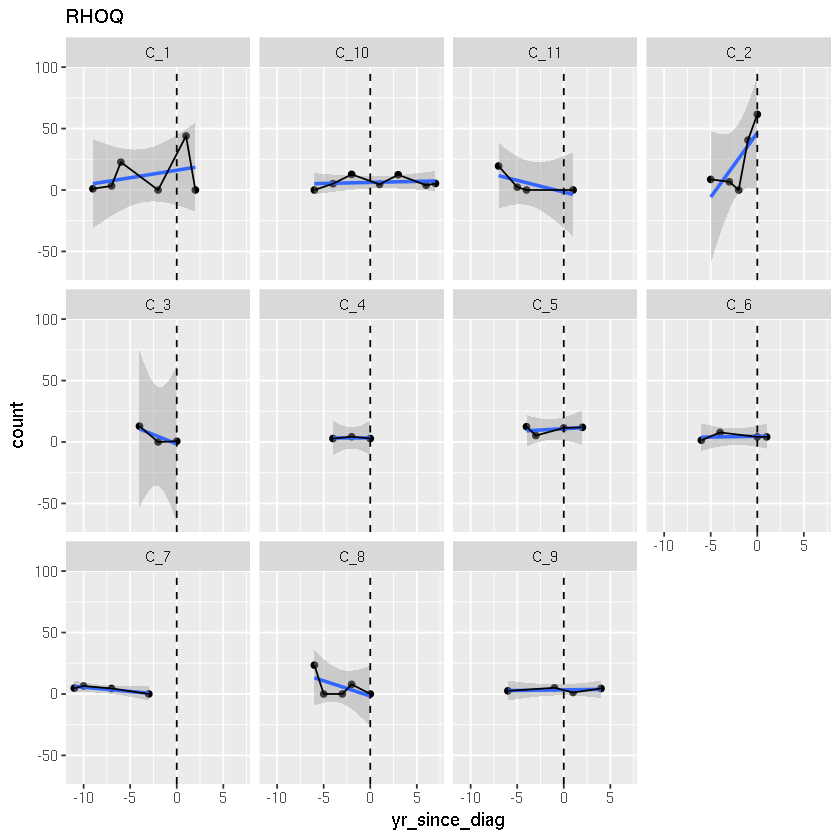

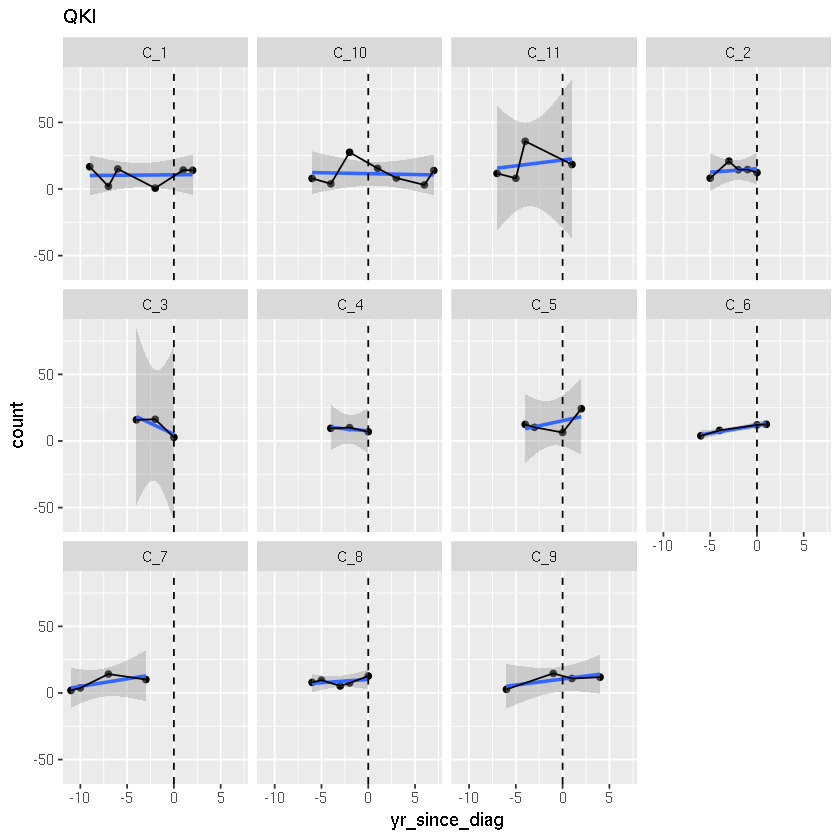

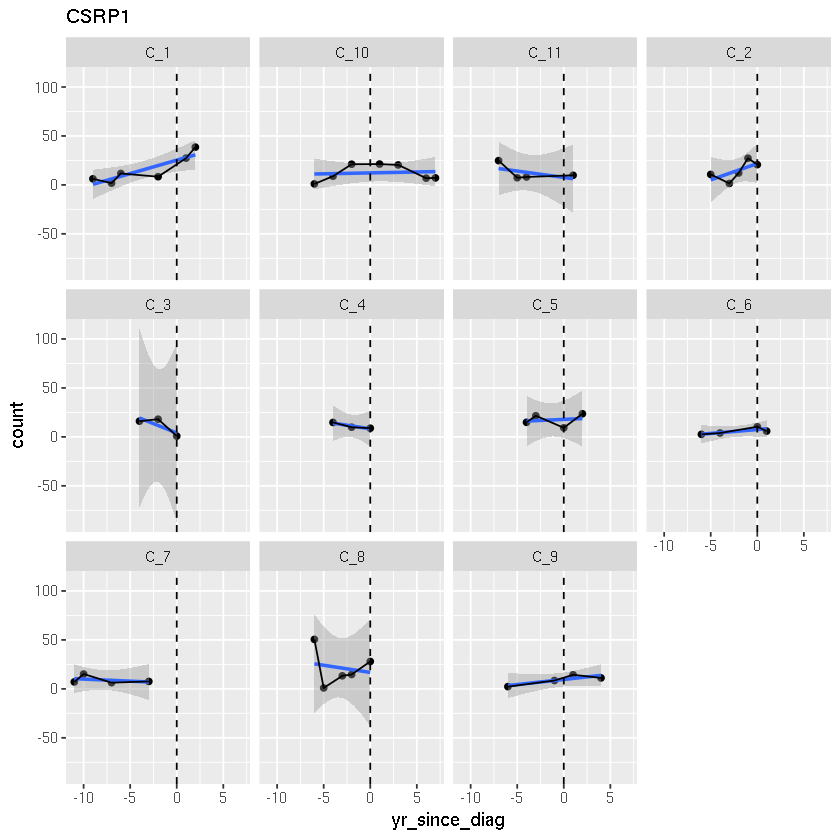

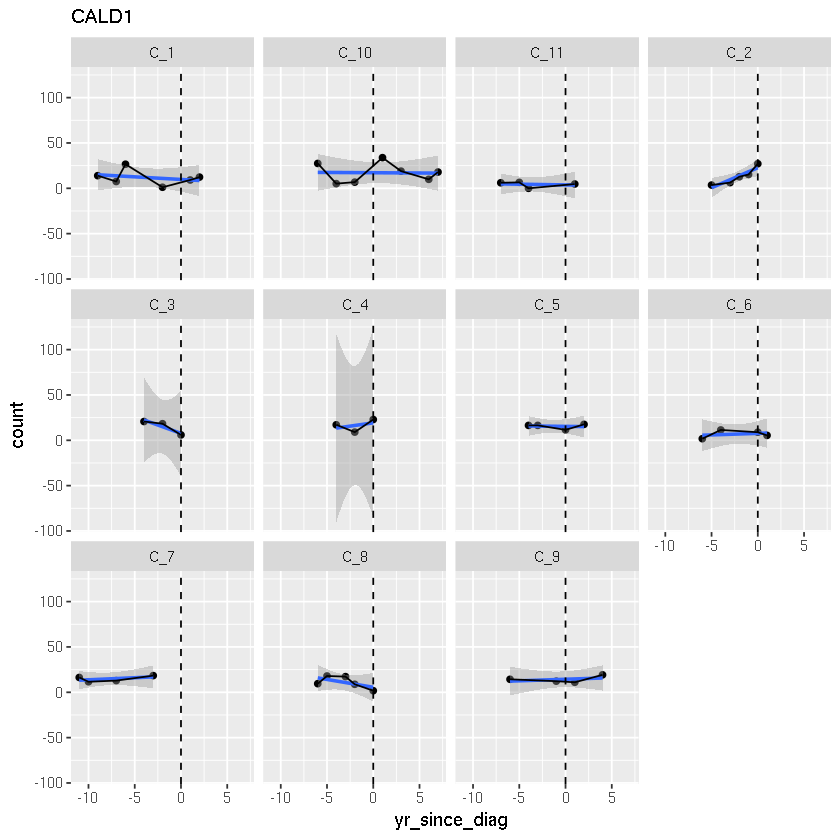

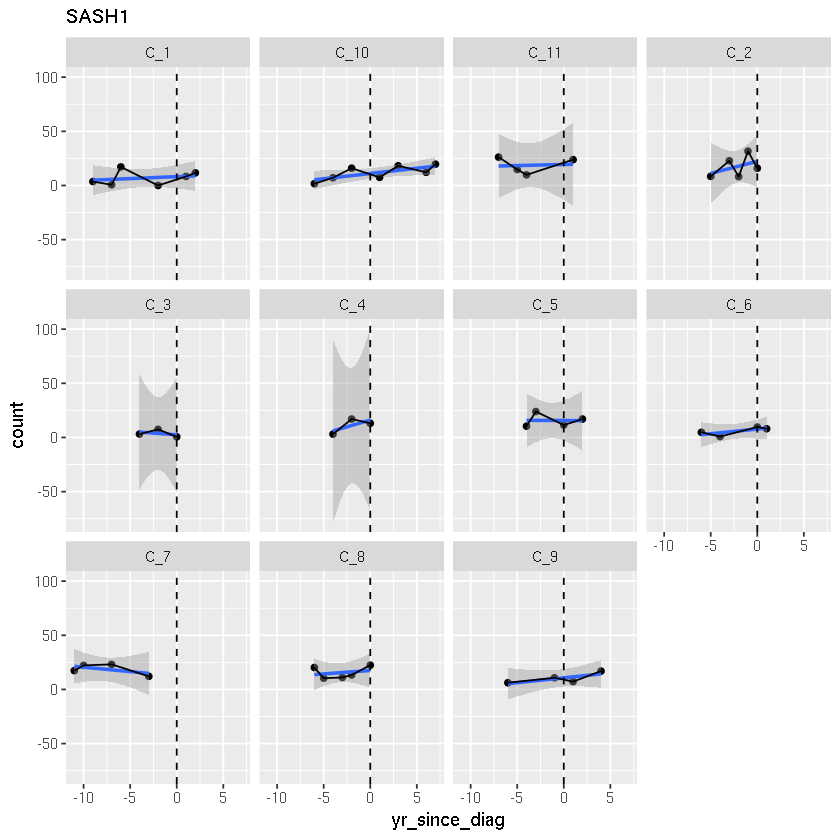

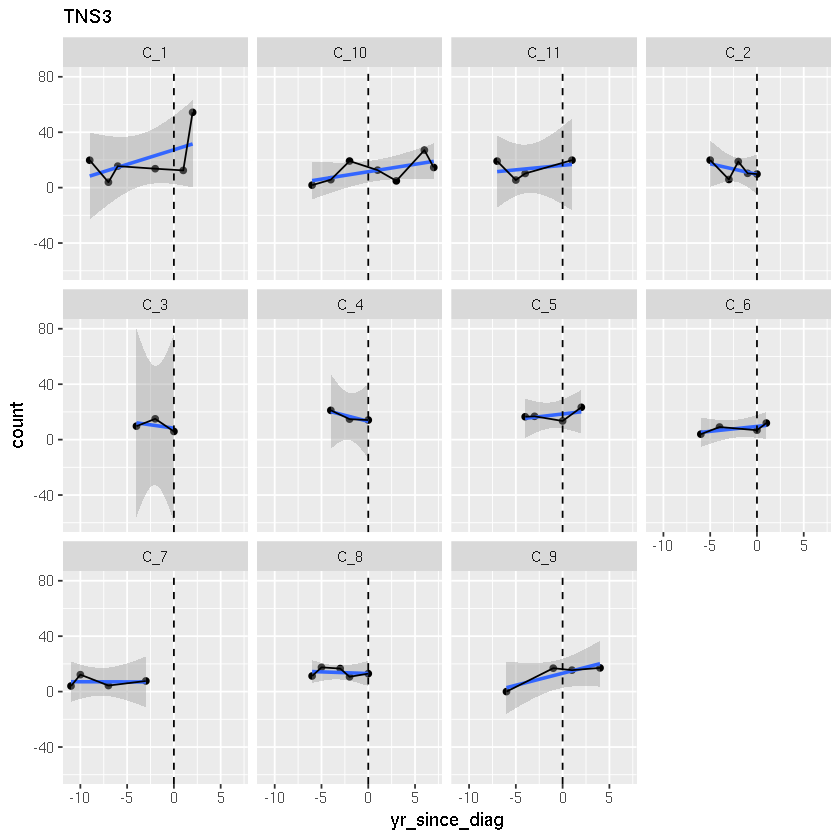

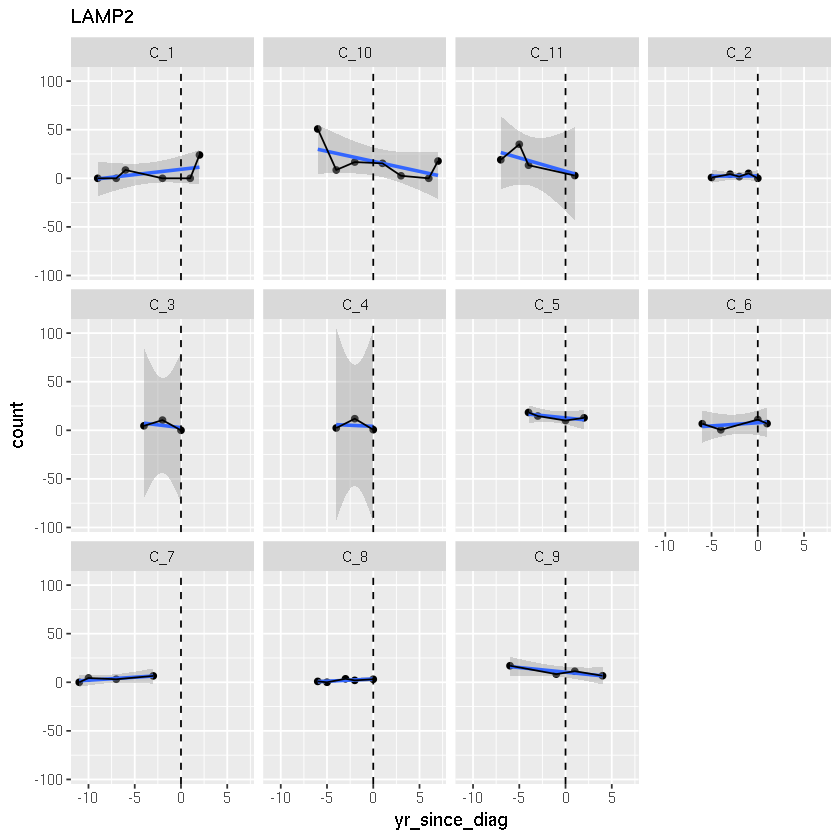

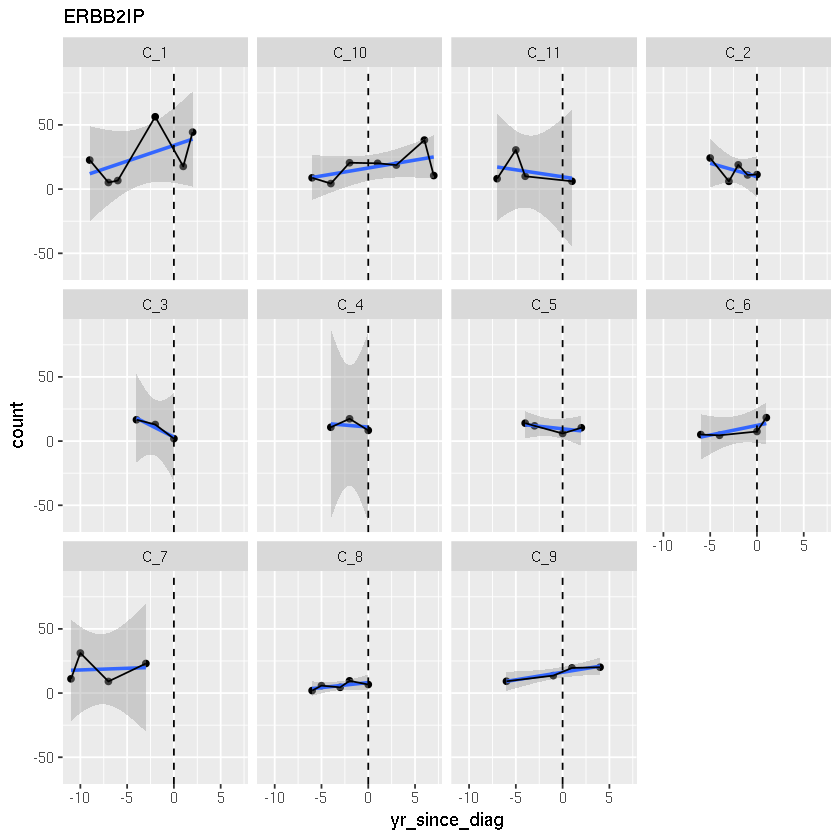

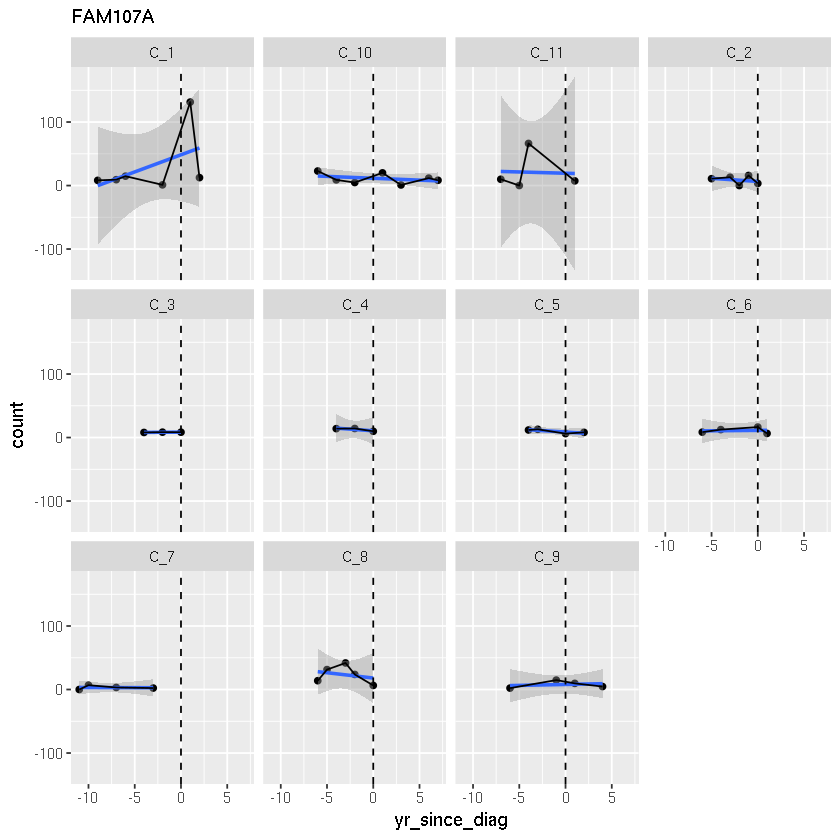

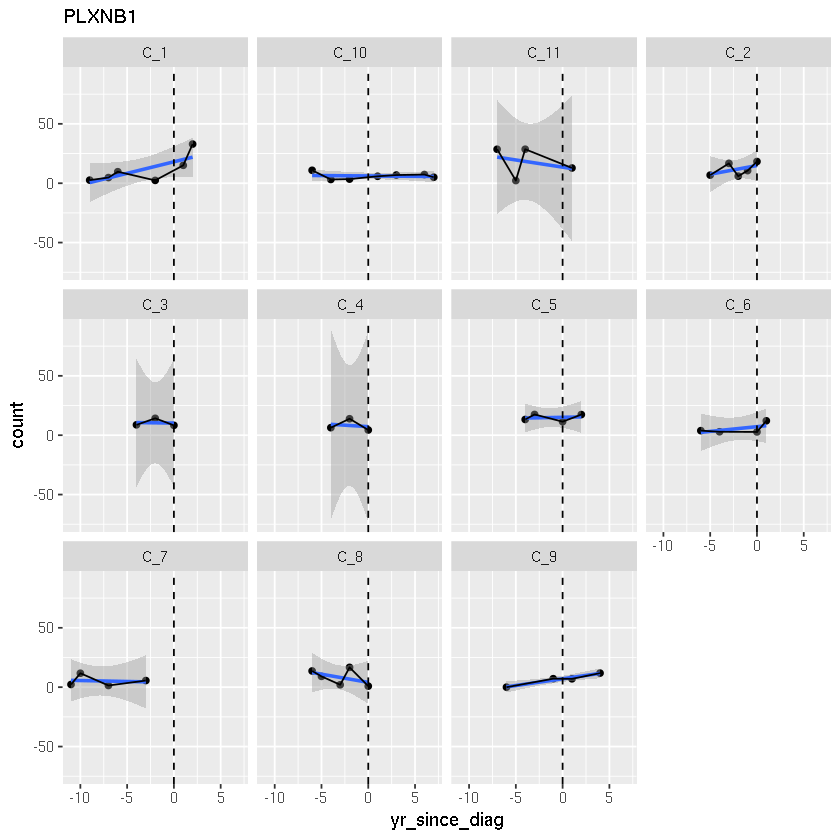

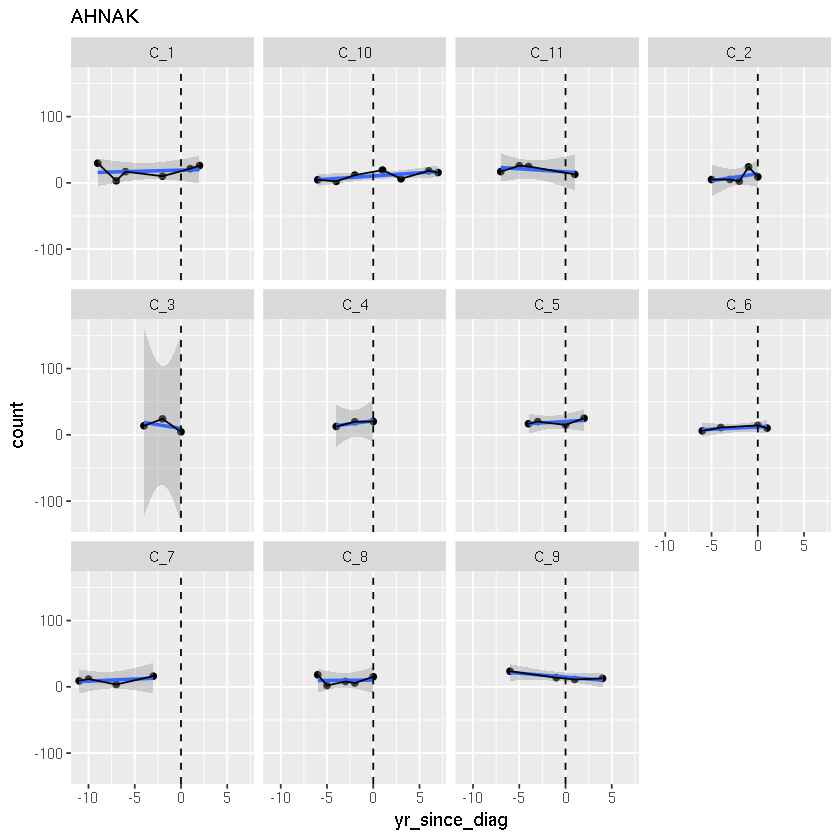

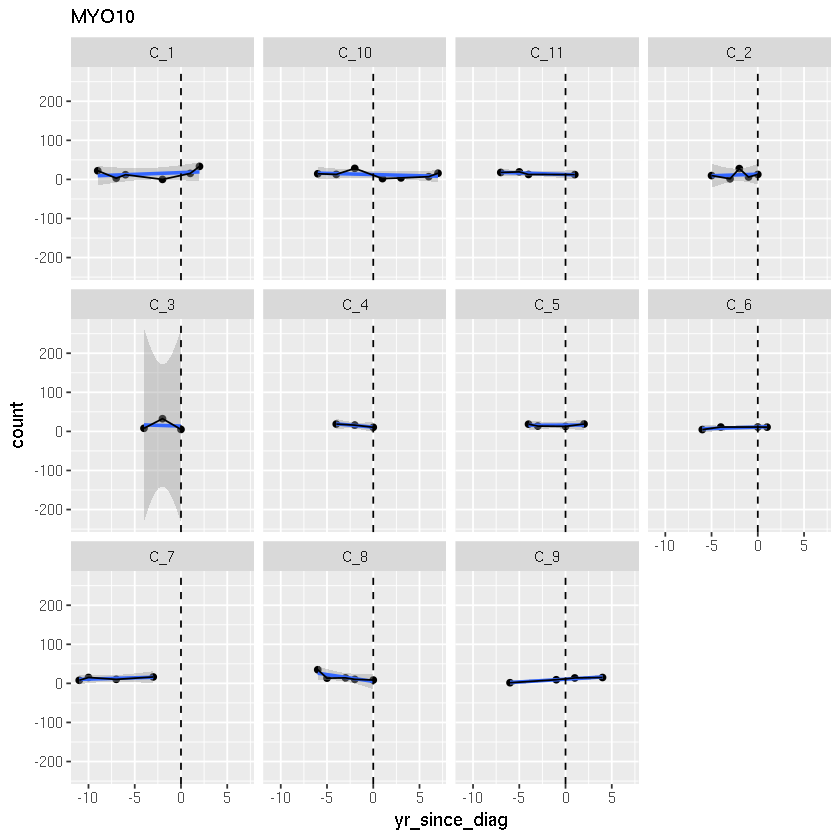

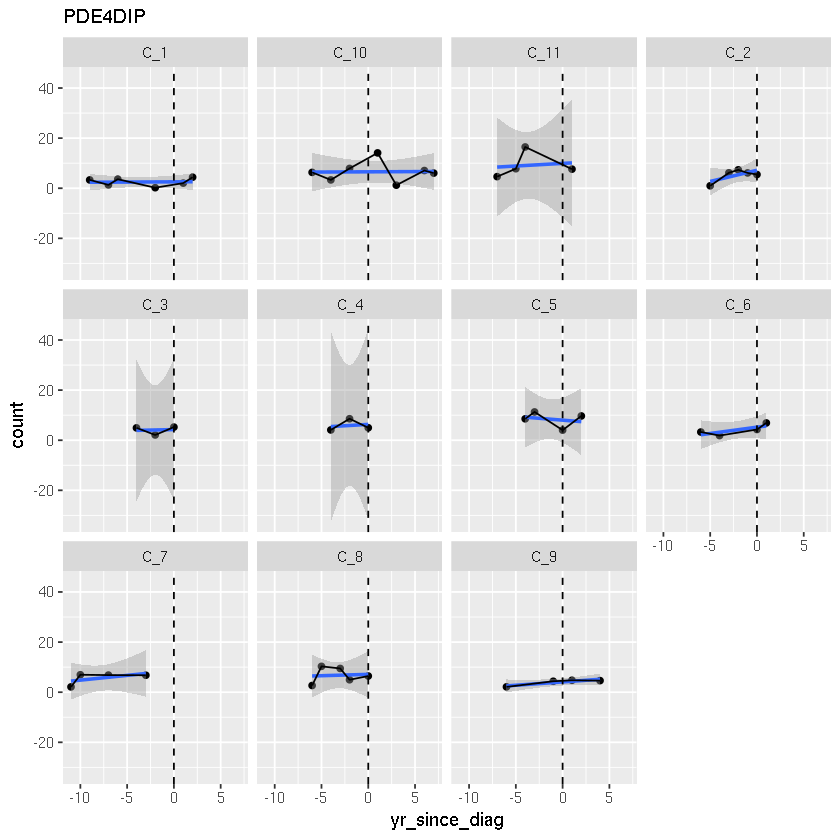

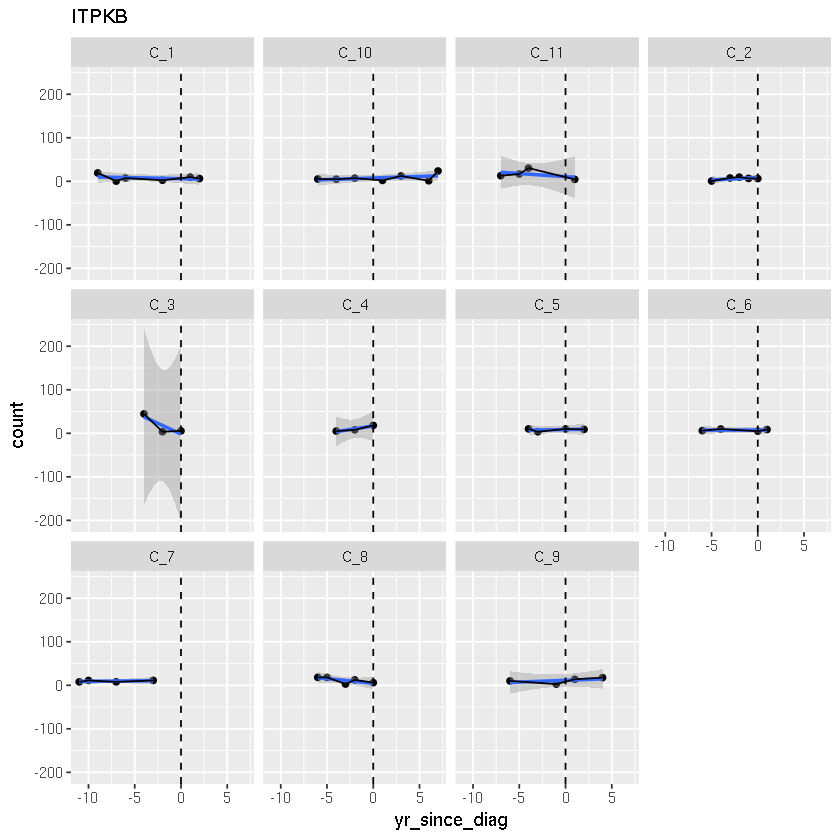

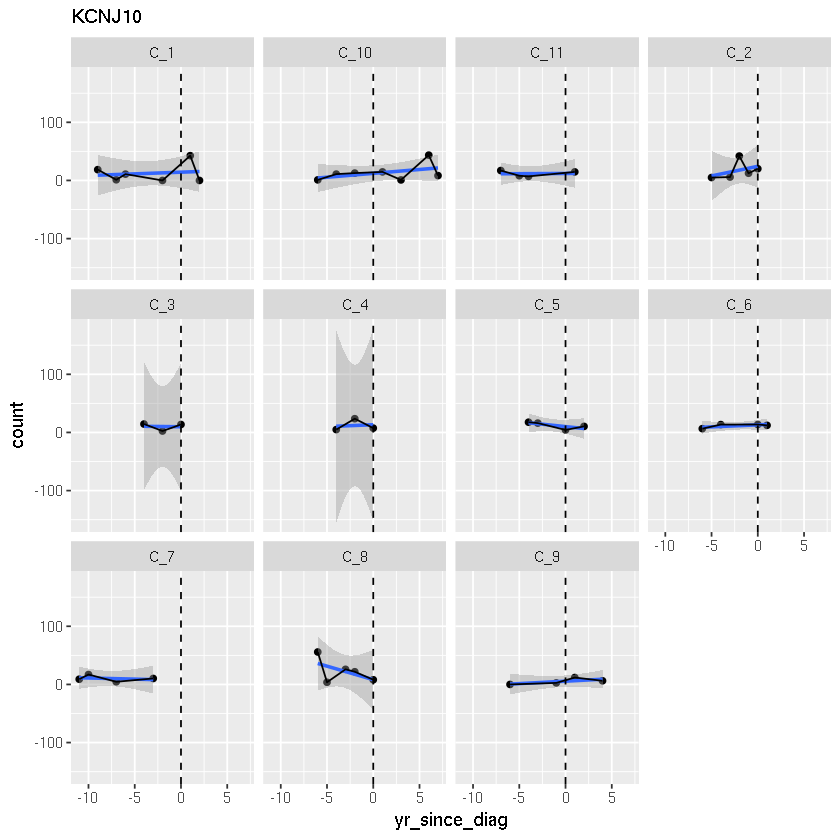

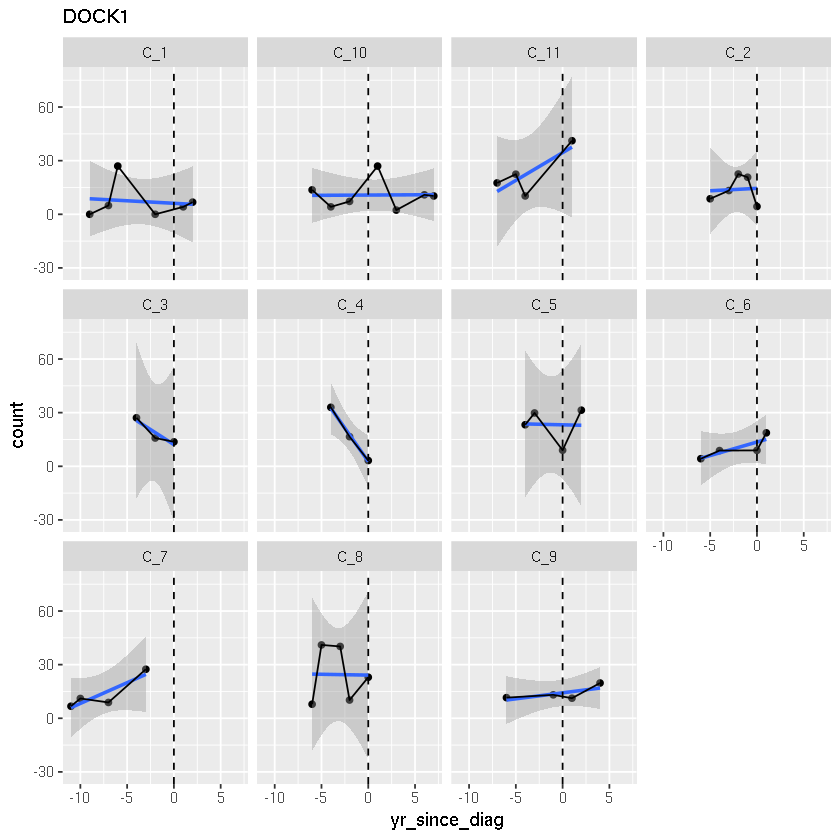

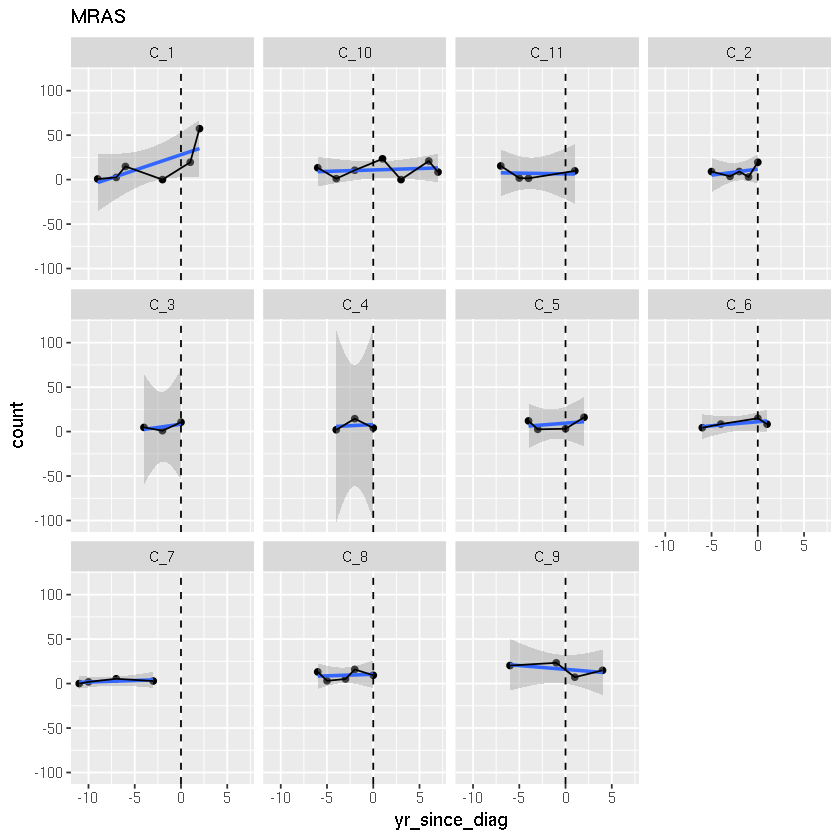

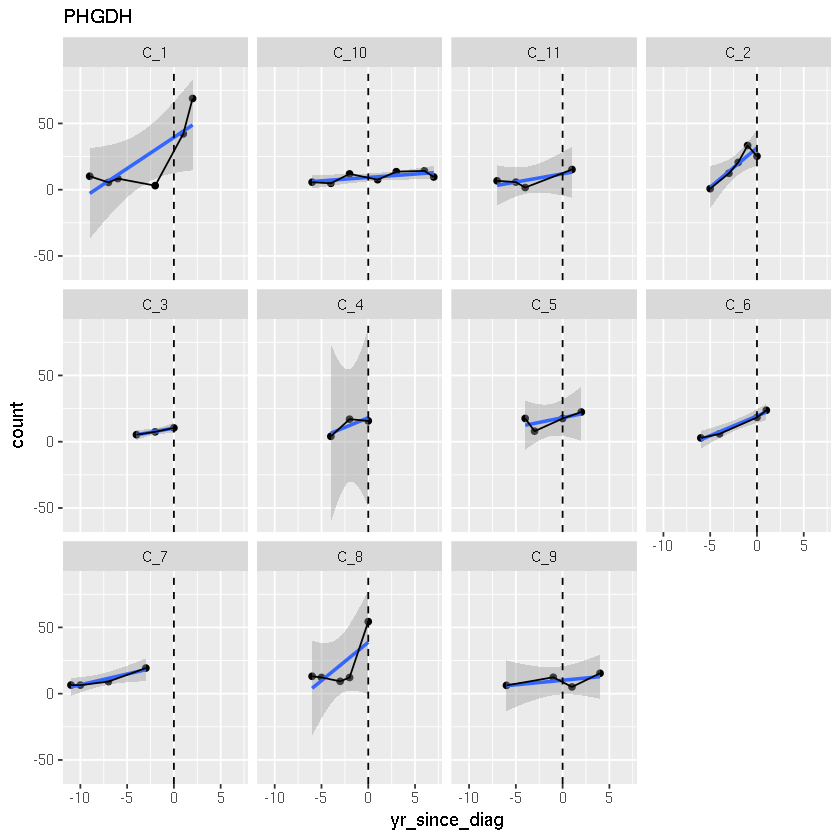

In [77]:
# look at all upregulated genes over time
for (g in up.ampgenes) {
    dt <- counts.longdt %>%
        filter(gene_name %in% g, group=="converter")
    # dt
    show(ggplot(dt, aes(x=yr_since_diag,y=count)) + geom_point() + geom_smooth(method =  "lm") +
        geom_vline(xintercept = 0, linetype= "dashed") + 
        geom_line() + facet_wrap(~donorID) + ggtitle(g))
}
# looks promising

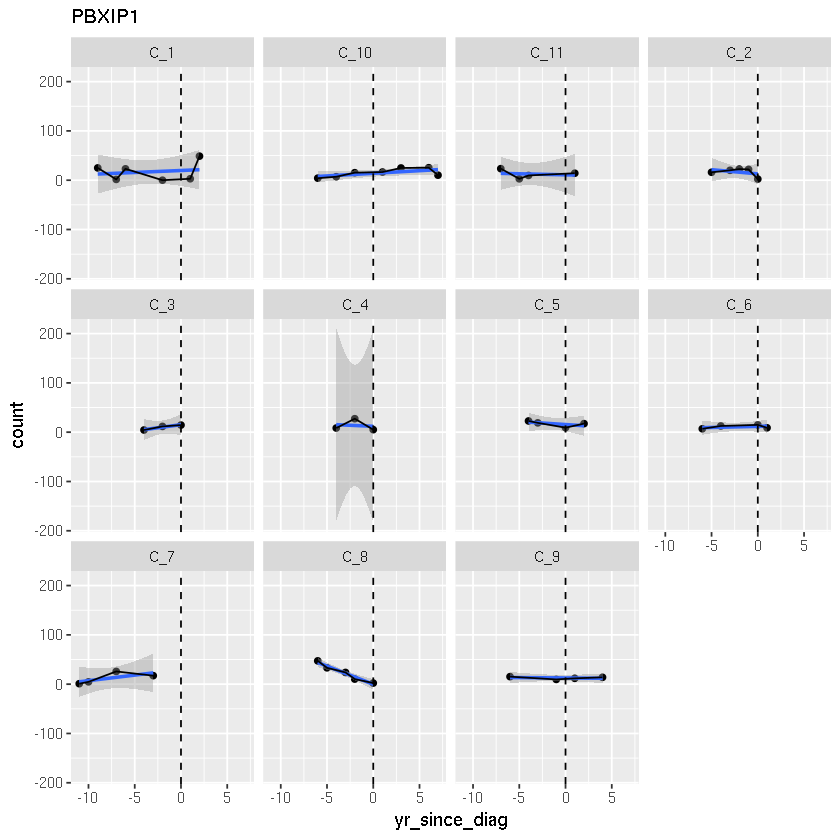

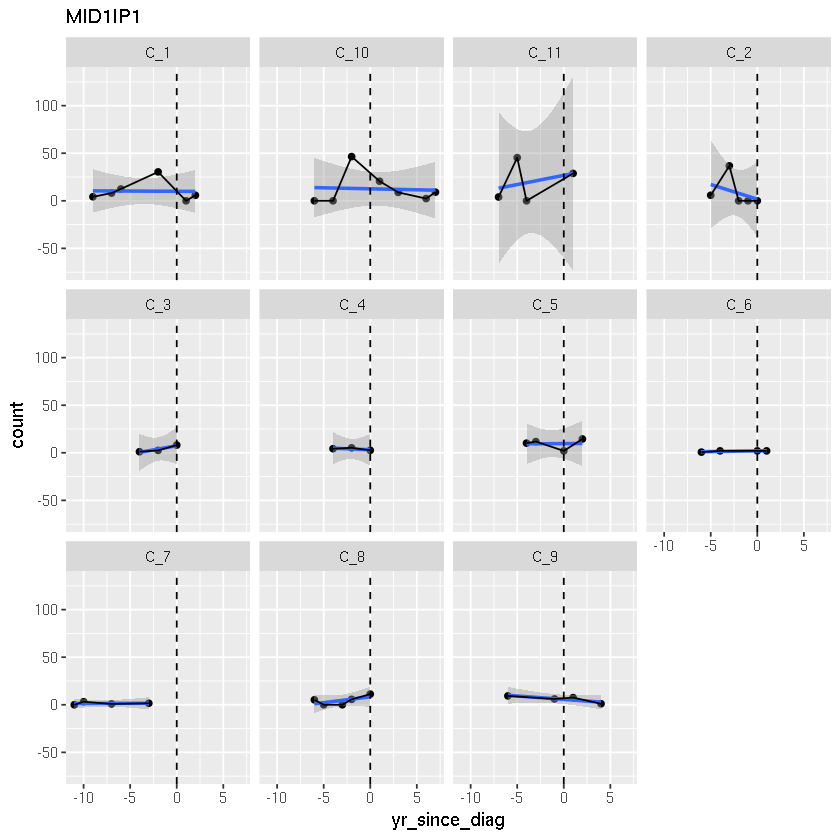

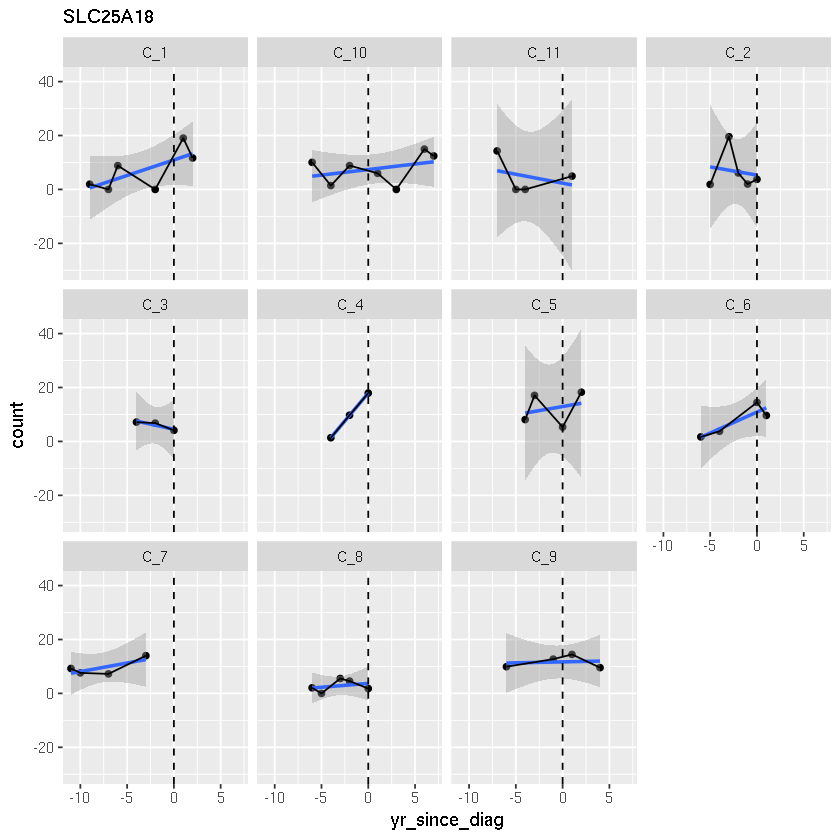

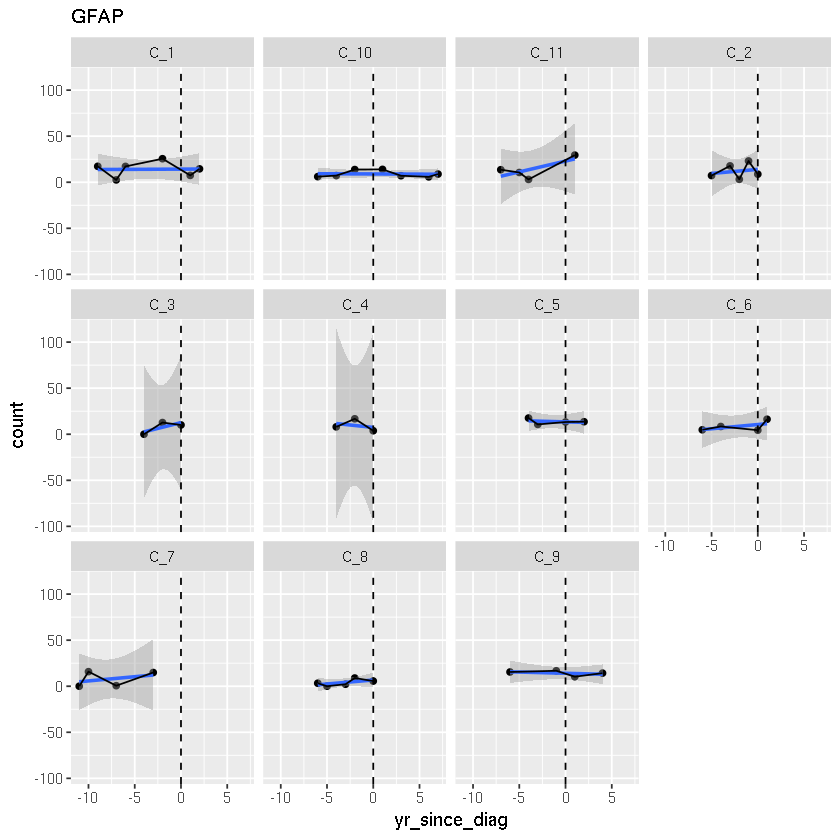

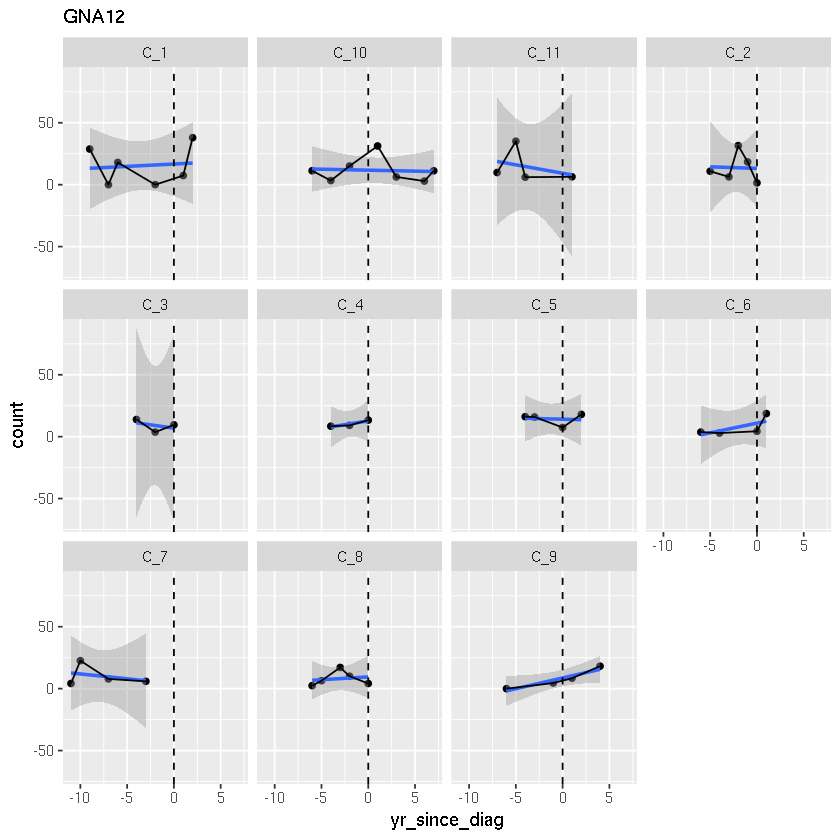

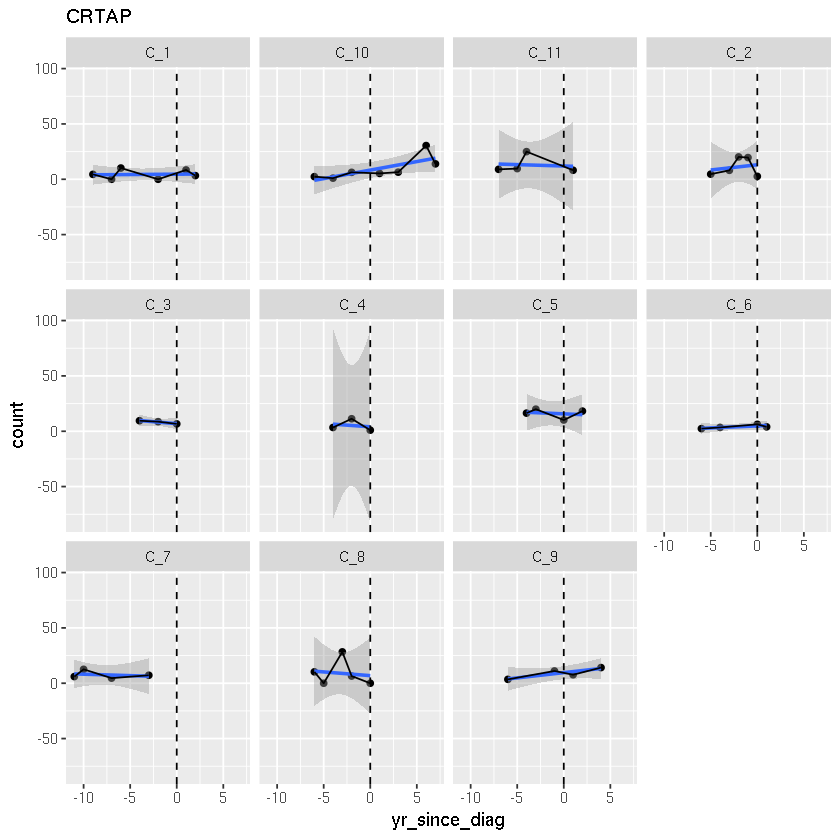

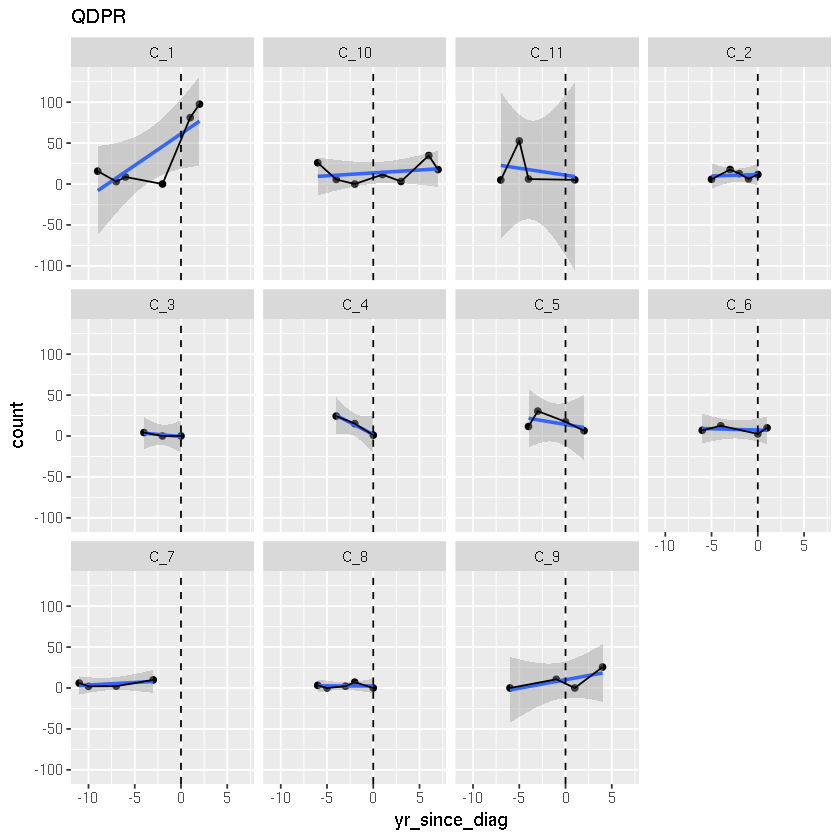

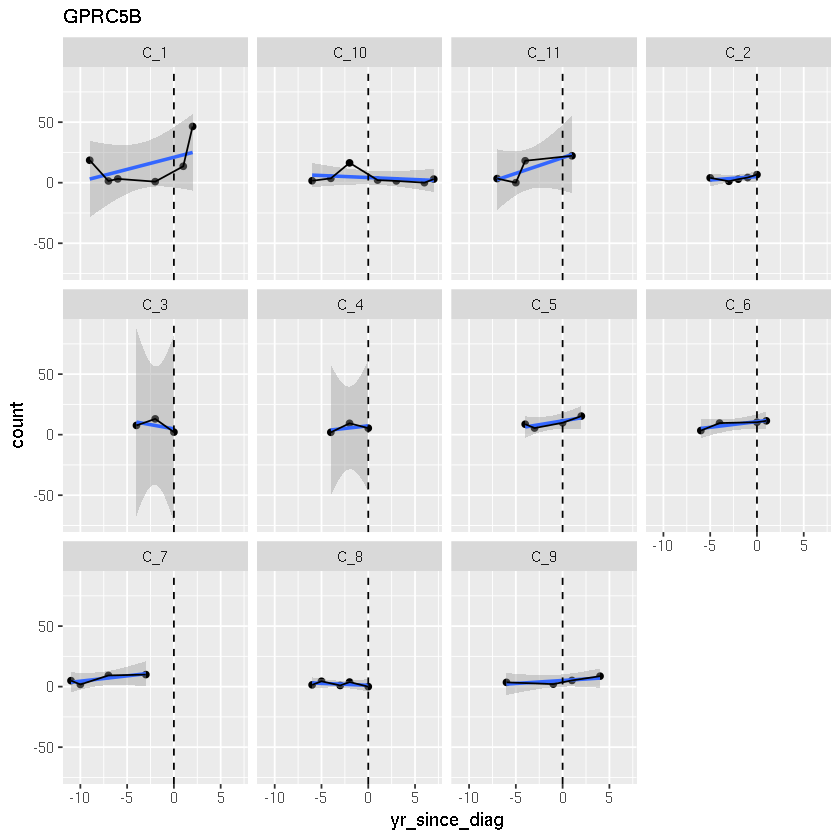

In [78]:
# look at all downregulated genes over time
for (g in down.ampgenes) {
    dt <- counts.longdt %>%
        filter(gene_name %in% g, group=="converter")
    # dt
    show(ggplot(dt, aes(x=yr_since_diag,y=count)) + geom_point() + geom_smooth(method =  "lm") +
        geom_vline(xintercept = 0, linetype= "dashed") + 
        geom_line() + facet_wrap(~donorID) + ggtitle(g))
}
# downreg looks a little less promising

In [79]:
head(counts.longdt)

gene_id         gene_name    gene_biotype                       sample_id
1 ENSG00000223972 DDX11L1      transcribed_unprocessed_pseudogene C_1_01_1 
2 ENSG00000227232 WASH7P       unprocessed_pseudogene             C_1_01_1 
3 ENSG00000278267 MIR6859-1    miRNA                              C_1_01_1 
4 ENSG00000243485 RP11-34P13.3 lincRNA                            C_1_01_1 
5 ENSG00000274890 MIR1302-2    miRNA                              C_1_01_1 
6 ENSG00000237613 FAM138A      lincRNA                            C_1_01_1 
  count donorID group     age_death sex braak_stage Year_diagnosis APOE_status
1 0     C_1     converter 91        F   3           2010           ε3/ε4      
2 0     C_1     converter 91        F   3           2010           ε3/ε4      
3 0     C_1     converter 91        F   3           2010           ε3/ε4      
4 0     C_1     converter 91        F   3           2010           ε3/ε4      
5 0     C_1     converter 91        F   3           2010           ε3/ε4      
6 0     C_1     converter 91        F   3           2010           ε3/ε4      
  year yr_since_diag
1 2001 -9           
2 2001 -9           
3 2001 -9           
4 2001 -9           
5 2001 -9           
6 2001 -9